### Import dependencies

In [1]:
import numpy as np
import scipy as sp
import netCDF4 as nC4
import lmoments3 as lm3
# import lmoments3.distr
# import lmoments3.stats
import scipy.signal
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import eofs
from cdo import Cdo
cdo = Cdo(tempdir='/network/aopp/chaos/pred/leach/.cdo_temp_files1')
# uncomment the below if you want to clean up the temporary directory
cdo.cleanTempDir()
import cartopy
from cartopy import crs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
import xarray as xr
import xskillscore as xs
import os
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import sys
import glob
import datetime
import time
import multiprocessing
import tqdm
import cmocean
from shapely.geometry.polygon import LinearRing

import pyarrow as pa
import pyarrow.parquet as pq

sys.path.append('/home/leach/Downloads/')
import ScientificColourMaps6 as SCM6

from IPython.display import display, clear_output

# import my own statistics repository
from mystatsfunctions import LMoments,OLSE

## Matplotlib rcparams setup:
matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11
# matplotlib.rcParams['font.weight']=400
matplotlib.rcParams['image.cmap']='cmo.ice'
matplotlib.rcParams['axes.prop_cycle']=matplotlib.cycler('color',['011936','FF7D00','225560','BFACAA','D72638','788C9B','A33F00','7CAAB0','685655','EB767C'])
matplotlib.rcParams['axes.formatter.limits']=-3,3
# matplotlib.rcParams['axes.labelweight']=300
matplotlib.rcParams['legend.frameon']=False
matplotlib.rcParams['boxplot.whiskers']=(5,95)
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.showfliers']=False
matplotlib.rcParams['boxplot.medianprops.color']='black'
matplotlib.rcParams['errorbar.capsize']=5
matplotlib.rcParams['hist.bins']='auto'
plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline

In [2]:
## plotting functions:

def add_lat_lon_ticks(ax,lat=True,lon=True):
    if lon:
        ax.set_xticks(np.arange(-20,50,10), crs=crs.PlateCarree())
        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        ax.xaxis.set_major_formatter(lon_formatter)
    if lat:
        ax.set_yticks(np.arange(40,75,10), crs=crs.PlateCarree())
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)

## Import Data

#### Useful definitions
Defines the PRUDENCE region extents and imports the a land-sea mask.

In [3]:
## define EU domain:
EU_rg = "-27,45,33,73.5"

## define PRUDENCE region extents:
PD_rg = dict(zip(['BI','IP','FR','CE','SC','AL','MD','EE'],['-10,2,50,59','-10,3,36,44','-5,5,44,50','2,16,48,55','5,30,55,70','5,15,44,48','3,25,36,44','16,30,44,55']))
print(PD_rg)

## get land-sea mask & inversion:
lsm = cdo.setctomiss('0',input= '-gtc,0.5 ../../ERA5/ERA5_land_sea_mask.nc')
lsm_inv = cdo.setctomiss('0',input= '-ltc,0.5 ../../ERA5/ERA5_land_sea_mask.nc')

{'BI': '-10,2,50,59', 'IP': '-10,3,36,44', 'FR': '-5,5,44,50', 'CE': '2,16,48,55', 'SC': '5,30,55,70', 'AL': '5,15,44,48', 'MD': '3,25,36,44', 'EE': '16,30,44,55'}


### Get the operational forecast, M-climate and ERA5 reanalysis

In [4]:
## list of forecast start dates
fcdates = [x.split('/')[-1].split('_')[0] for x in glob.glob('../../OPERATIONAL/EU_FEB_19/sfc/*_sfc.nc')]

#### mx2t

operational forecast

In [5]:
## get operational forecasts:

op_mx2t = []

for fcdate in fcdates:
    
    pf = xr.open_dataset('../../OPERATIONAL/EU_FEB_19/sfc/'+fcdate+'_sfc.nc',chunks={'time':1,'number':10}).mx2t.loc['2019-02-25':'2019-02-27'].max('time')
    cf = xr.open_dataset('../../OPERATIONAL/EU_FEB_19/sfc/ctrl/'+fcdate+'_sfc.nc',chunks={'time':1}).mx2t.loc['2019-02-25':'2019-02-27'].max('time')
    op_mx2t += [xr.concat([pf,cf.expand_dims({'number':[51]})],dim='number').expand_dims({'inidate':[fcdate]})]
    
op_mx2t = xr.concat(op_mx2t,dim='inidate')

M-climate (model climatology based on reforecasts)

In [6]:
## get reforecast data:
### need to grab reforecast data for each inidate:

rfc_dates = {
    '2019-02-04':['2019-01-'+'{:0>2}'.format(x) for x in [21,24,28,31]]+['2019-02-'+'{:0>2}'.format(x) for x in [4,7,11,14,18]],
    '2019-02-11':['2019-01-'+'{:0>2}'.format(x) for x in [28,31]]+['2019-02-'+'{:0>2}'.format(x) for x in [4,7,11,14,18,21,25]],
    '2019-02-17':['2019-01-'+'{:0>2}'.format(x) for x in [31]]+['2019-02-'+'{:0>2}'.format(x) for x in [4,7,11,14,18,21,25,28]],
    '2019-02-23':['2019-02-'+'{:0>2}'.format(x) for x in [7,11,14,18,21,25,28]]+['2019-03-'+'{:0>2}'.format(x) for x in [4,7]],
}

basedir = '/network/aopp/chaos/pred/leach/OPERATIONAL/EU_FEB_19/sfc/M-climate/2019-02-17/'

rfc_days = {
    '2019-02-04':[x-4 for x in [25,26,27]],
    '2019-02-11':[x-11 for x in [25,26,27]],
    '2019-02-17':[x-17 for x in [25,26,27]],
    '2019-02-23':[x-23 for x in [25,26,27]],
}

def get_rfc_data(fcdate):
    
    print('getting rfc_data for '+fcdate)
    
    rfc_data = []

    for i,rfc_date in enumerate(rfc_dates[fcdate]):

        cf_file = basedir+'rfc_init_'+rfc_date+'_cf.nc'
        pf_file = basedir+'rfc_init_'+rfc_date+'_pf.nc'

        year,mon,day = [int(x) for x in rfc_date.split('-')]
        datetimes = ','.join([(datetime.datetime(year,mon,day)+datetime.timedelta(days=y)-pd.DateOffset(years=x)).strftime('%Y-%m-%d') for x in np.arange(1,21) for y in rfc_days[fcdate]])
        
        cf = xr.open_dataset(cdo.yearmax(input="-select,date="+datetimes+" -selname,mx2t6 "+cf_file),chunks = {'time':10}).expand_dims({'number':[11]})
        pf = xr.open_dataset(cdo.yearmax(input="-select,date="+datetimes+" -selname,mx2t6 "+pf_file),chunks = {'time':10})
        rfc_data += [xr.concat([pf,cf],dim='number').stack(rfc_number=['time','number']).assign_coords(rfc_number=np.arange(i*220,(i+1)*220))]
        cf.close()
        pf.close()

    return xr.concat(rfc_data,dim='rfc_number').expand_dims({'inidate':[fcdate]})

P1 = multiprocessing.Pool(processes=4)
rfc_mx2t = P1.map(get_rfc_data,list(rfc_dates.keys()))
P1.close()

rfc_mx2t = xr.concat(rfc_mx2t,dim='inidate')

getting rfc_data for 2019-02-04getting rfc_data for 2019-02-11getting rfc_data for 2019-02-23getting rfc_data for 2019-02-17





ERA5

In [8]:
ERA5_mx2t = xr.open_dataset('../../ERA5/EU_FEB_19/ERA5_sfc_2019.nc').mx2t.loc['2019-02-25':'2019-02-27'].max('time')

### Z500

operational forecast

In [9]:
## get operational forecasts:

op_z500 = []

for fcdate in fcdates:
    
    pf = xr.open_dataset('../../OPERATIONAL/EU_FEB_19/plev/'+fcdate+'.nc',chunks={'time':1,'number':10}).Z500.loc['2019-02-25':'2019-02-27'].resample(time='1D').mean()
    cf = xr.open_dataset('../../OPERATIONAL/EU_FEB_19/plev/ctrl/'+fcdate+'.nc',chunks={'time':1}).Z500.loc['2019-02-25':'2019-02-27'].resample(time='1D').mean()
    op_z500 += [xr.concat([pf,cf.expand_dims({'number':[51]})],dim='number').expand_dims({'inidate':[fcdate]})]
    
op_z500 = xr.concat(op_z500,dim='inidate')

M-climate (model climatology based on reforecasts)

In [10]:
basedir = '/network/aopp/chaos/pred/leach/OPERATIONAL/EU_FEB_19/plev/M-climate/2019-02-17/'

def get_rfc_data_Z500(fcdate):
    
    print('getting rfc_data for '+fcdate)
    
    rfc_data = []

    for i,rfc_date in enumerate(rfc_dates[fcdate]):

        cf_file = basedir+'rfc_init_'+rfc_date+'_Z500_cf.nc'
        pf_file = basedir+'rfc_init_'+rfc_date+'_Z500_pf.nc'

        year,mon,day = [int(x) for x in rfc_date.split('-')]
        datetimes = ','.join([(datetime.datetime(year,mon,day)+datetime.timedelta(days=y)-pd.DateOffset(years=x)).strftime('%Y-%m-%d') for x in np.arange(1,21) for y in rfc_days[fcdate]])
        
        cf = xr.open_dataset(cdo.yearmean(input="-select,date="+datetimes+" -selname,z "+cf_file),chunks = {'time':10}).expand_dims({'number':[11]})
        pf = xr.open_dataset(cdo.yearmean(input="-select,date="+datetimes+" -selname,z "+pf_file),chunks = {'time':10})
        rfc_data += [xr.concat([pf,cf],dim='number').stack(rfc_number=['time','number']).assign_coords(rfc_number=np.arange(i*220,(i+1)*220))]
        cf.close()
        pf.close()

    return xr.concat(rfc_data,dim='rfc_number').expand_dims({'inidate':[fcdate]})

P1 = multiprocessing.Pool(processes=4)
rfc_z500 = P1.map(get_rfc_data_Z500,list(rfc_dates.keys()))
P1.close()

rfc_z500 = xr.concat(rfc_z500,dim='inidate')

getting rfc_data for 2019-02-04getting rfc_data for 2019-02-11getting rfc_data for 2019-02-17getting rfc_data for 2019-02-23





ERA5

In [14]:
ERA5_z500 = xr.open_dataset('../../ERA5/EU_FEB_19/ERA5_plev_500-850_2019.nc').z.loc['2019-02-25':'2019-02-27'].sel(level=500).resample(time='1D').mean()

### Postprocessing

#### mx2t data to get regional mean values
For each of the operational forecast / M-climate and ERA5 data.

In [15]:
## derive regional data:

lsm_xr = xr.open_dataset(lsm).lsm.fillna(0).astype(bool)
lsm_xr = lsm_xr.assign_coords(longitude=(((lsm_xr.longitude + 180) % 360) - 180)).sortby('longitude')

PD_rg_xr = pd.DataFrame(columns=['lon_1','lon_2','lat_1','lat_2'])

for RG in PD_rg.keys():
    PD_rg_xr.loc[RG] = [float(x) for x in PD_rg[RG].split(',')]

In [16]:
ERA5_mx2t_rg = []
op_mx2t_rg = []
rfc_mx2t_rg = []

for RG in PD_rg_xr.index:
    
    lsm_RG = lsm_xr.sel(longitude=slice(PD_rg_xr.loc[RG,'lon_1'],PD_rg_xr.loc[RG,'lon_2']),latitude=slice(PD_rg_xr.loc[RG,'lat_2'],PD_rg_xr.loc[RG,'lat_1']))
    lat_weights = np.cos(np.deg2rad(lsm_RG.latitude))
    
    # ensembles
    rg_event_data = op_mx2t.sel(longitude=slice(PD_rg_xr.loc[RG,'lon_1'],PD_rg_xr.loc[RG,'lon_2']),latitude=slice(PD_rg_xr.loc[RG,'lat_2'],PD_rg_xr.loc[RG,'lat_1']))
    op_mx2t_rg += [rg_event_data.where(lsm_RG).weighted(lat_weights).mean(['latitude','longitude']).expand_dims({'RG':[RG]})]
    
    # M-climate
    rg_event_data_rfc = rfc_mx2t.mx2t6.sel(longitude=slice(PD_rg_xr.loc[RG,'lon_1'],PD_rg_xr.loc[RG,'lon_2']),latitude=slice(PD_rg_xr.loc[RG,'lat_2'],PD_rg_xr.loc[RG,'lat_1']))
    rfc_mx2t_rg += [rg_event_data_rfc.where(lsm_RG).weighted(lat_weights).mean(['latitude','longitude']).expand_dims({'RG':[RG]})]
    
    # ERA5
    rg_ERA5_data = ERA5_mx2t.sel(longitude=slice(PD_rg_xr.loc[RG,'lon_1'],PD_rg_xr.loc[RG,'lon_2']),latitude=slice(PD_rg_xr.loc[RG,'lat_2'],PD_rg_xr.loc[RG,'lat_1']))
    ERA5_mx2t_rg += [rg_ERA5_data.where(lsm_RG).weighted(lat_weights).mean(['latitude','longitude']).expand_dims({'RG':[RG]})]
    
op_mx2t_rg = xr.concat(op_mx2t_rg,dim='RG').compute()
ERA5_mx2t_rg = xr.concat(ERA5_mx2t_rg,dim='RG').compute()
rfc_mx2t_rg = xr.concat(rfc_mx2t_rg,dim='RG').compute()

#### Z500 data to get correlations against ERA5
For each of the operational forecast / M-climate data.

In [19]:
## get correlations over 2019-02-25 to 2019-02-27
Z500_corr_23_27 = xs.pearson_r(op_z500.mean('time'),ERA5_z500.mean('time'),dim=['latitude','longitude'],weights = xr.broadcast(np.cos(np.deg2rad(ERA5_z500.latitude)),ERA5_z500.mean('time'))[0])
Z500_corr_23_27 = Z500_corr_23_27.assign_coords(inidate=pd.DatetimeIndex(Z500_corr_23_27.inidate)).sortby('inidate').to_pandas()

## and for reforecasts:
Z500_corr_rfc = xs.pearson_r(rfc_z500.z,ERA5_z500.mean('time'),dim=['latitude','longitude'],weights = xr.broadcast(np.cos(np.deg2rad(ERA5_z500.latitude)),ERA5_z500.mean('time'))[0])
Z500_corr_rfc = Z500_corr_rfc.assign_coords(inidate=pd.DatetimeIndex(Z500_corr_rfc.inidate)).sortby('inidate').to_pandas()

/network/aopp/chaos/pred/leach/software/miniconda3/lib/python3.7/site-packages/dask/array/gufunc.py:431: PerformanceWarning: Increasing number of chunks by factor of 23
  func, loop_output_dims, *arginds, concatenate=True, **kwargs


## Create the figure

Text(1.02, 1, 'B')

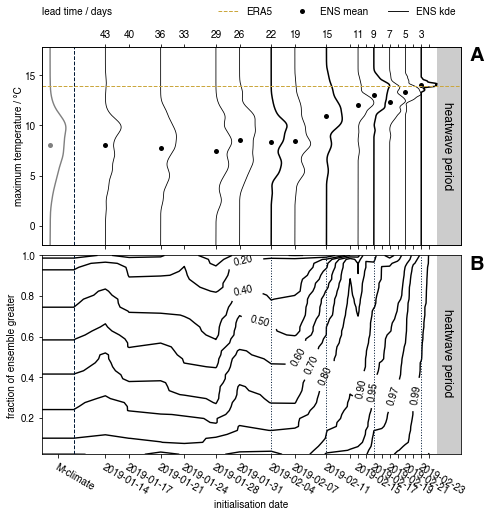

In [24]:
## create individual region plots:

fig = plt.figure(figsize=(7.5,7.5))
gs = fig.add_gridspec(2,1,wspace=0.15,hspace=0.05)

# Panel A:
ax = fig.add_subplot(gs[:1,:])

## pick colors for figure
ens_clrs = dict(zip(['ERA5','OP','PI','INC'],['#CBA73D','#39398E','#268071','#6F2C86']))

## choose lead times to show:
fc_lead_times = ['2019-01-'+'{:0>2}'.format(x) for x in [14,21,28,31]] + ['2019-02-'+'{:0>2}'.format(x) for x in [4,7,11,15,17,19,21,23]]

## choose region to show:
for i,RG in enumerate(['BI']):

    lead_times_sorted = sorted(fc_lead_times)
    ## compute kernel density estimates for tmax forecast / fldcor
    kde_bw=0.25
    kde_est_tmax = [sp.stats.gaussian_kde(op_mx2t_rg.sel(RG=RG,inidate=x).values-273.15,kde_bw) for x in lead_times_sorted]

    ## compute y-axis limits based on range of all forecasts
    ylims = [op_mx2t_rg.sel(RG=RG).min()-273.15,op_mx2t_rg.sel(RG=RG).max()-273.15]
    ylims += np.diff(ylims)*np.array([-0.2,0.2])

    line_spacing = 1.1
    lw0=0.8
    lw1=0.7
    lws = [lw0+lw1*(x in ['2019-02-04','2019-02-11','2019-02-17','2019-02-23']) for x in lead_times_sorted]

    choose_plot_type = 'kde'

    if choose_plot_type == 'kde':
        ## plot forecast kdes
        [ax.plot(2*24*3600*kde_est_tmax[i].pdf(np.linspace(*ylims,500))/kde_est_tmax[i].pdf(np.linspace(*ylims,500)).max()+pd.to_datetime(x).timestamp(),np.linspace(*ylims,500),c='k',lw=lws[i]) for i,x in enumerate(lead_times_sorted)]
        [ax.plot(pd.to_datetime(x).timestamp(),op_mx2t_rg.sel(RG=RG,inidate=x).mean('number')-273.15,'ok',ms=5,mec='none') for i,x in enumerate(lead_times_sorted)]

        ## add M-climate plot
        choose_rfc_inidate = '2019-02-11'
        kde_mclim = sp.stats.gaussian_kde(rfc_mx2t_rg.sel(RG=RG,inidate=choose_rfc_inidate).values.flatten()-273.15,kde_bw)
        ax.plot(2*24*3600*kde_mclim.pdf(np.linspace(*ylims,500))/kde_mclim.pdf(np.linspace(*ylims,500)).max()+pd.to_datetime('2019-01-07').timestamp(),np.linspace(*ylims,500),c='grey',lw=1.4)
        ax.plot(pd.to_datetime('2019-01-07').timestamp(),rfc_mx2t_rg.sel(RG=RG,inidate=choose_rfc_inidate).mean('rfc_number')-273.15,'o',c='grey',ms=5,mec='none')

    elif choose_plot_type == 'hist':
        ## plot forecast kdes
        [ax.hist(op_mx2t_rg.sel(RG=RG,inidate=x).values-273.15,bins=20,weights=[1/7]*51,histtype='step',orientation='horizontal',bottom=i*line_spacing,color='k',lw=lws[i]) for i,x in enumerate(lead_times_sorted)]
        [ax.plot(i*line_spacing,op_mx2t_rg.sel(RG=RG,inidate=x).mean('number')-273.15,'ok',ms=5,mec='none') for i,x in enumerate(lead_times_sorted)]

        ## add M-climate plot
        ax.hist(rfc_mx2t_rg.sel(RG=RG,inidate=choose_rfc_inidate).values.flatten()-273.15,bins=20,weights=[1/(7*1980/51)]*1980,histtype='step',orientation='horizontal',bottom=-1*line_spacing,color='grey',lw=1.4)
        ax.plot(-1*line_spacing,rfc_mx2t_rg.sel(RG=RG,inidate=choose_rfc_inidate).mean('rfc_number')-273.15,'o',c='grey',ms=5,mec='none')

    ## add ERA5 line
    ax.axhline(ERA5_mx2t_rg.sel(RG=RG)-273.15,color=ens_clrs['ERA5'],ls='--',lw=1,label='ERA5')

    ## add CRPS skill values
#     [ax.text(i*line_spacing+0.05,ylims[1]-0.5,str(round(op_crps_clim.loc[fcdate,RG],2)),va='top',ha='left',fontweight=['normal','bold'][fcdate in ['2019-02-04','2019-02-11','2019-02-17','2019-02-23']]) for i,fcdate in enumerate(lead_times_sorted)]

    ## optional: histogram plot
    # [ax[0].hist(tmax_forecasts_BI[x].flatten(),bottom=i*line_spacing,color='k',alpha=0.2,density=True,orientation='horizontal') for i,x in enumerate(lead_times_sorted)]

    ax.set_yticks(np.arange(-5,30,5))
    ax.set_ylim(*ylims)

    ax.set_ylabel('maximum temperature / \N{DEGREE SIGN}C',va='bottom',labelpad=0)

    ax.set_xlim(pd.to_datetime('2019-01-06 00:00:00').timestamp(),pd.to_datetime('2019-02-28 00:00:00').timestamp())
    ax.patch.set_alpha(0)
    ax.set_xticks([x.timestamp() for x in Z500_corr_23_27.index])
#     ax.set_xticklabels([])
    
ax.fill_between([pd.to_datetime('2019-02-25 00:00:00').timestamp(),pd.to_datetime('2019-02-28 00:00:00').timestamp()],-5,30,color='k',alpha=0.2,lw=0)
ax.text(0.982,0.5,'heatwave period',va='center',ha='right',transform=ax.transAxes,fontsize='large',rotation=270)

## plot layout:
ax.set_xticklabels('')#["M-climate"]+lead_times_sorted,rotation=-30,ha='left',rotation_mode="anchor")
# ax.set_xlabel('ENS initialisation date',labelpad=10)

## plot a single dot for the legend
ax.plot([],[],'ok',ms=5,mec='none',label='ENS mean')
ax.plot([],[],c='k',lw=0.9,label='ENS kde')

ax.axvline(pd.to_datetime('2019-01-10').timestamp(),lw=1,ls='--')

## add in second axis for lead time scale
axes1 = plt.twiny(ax)
axes1.set_xlim(pd.to_datetime('2019-01-06 00:00:00').timestamp(),pd.to_datetime('2019-02-28 00:00:00').timestamp())
axes1.patch.set_alpha(0)
axes1.set_xticks([x.timestamp() for x in Z500_corr_23_27.index])
axes1.set_xticklabels([x.days for x in pd.to_datetime('2019-02-26')-Z500_corr_23_27.index[:9]]+[item for sublist in [['',x.days] for x in pd.to_datetime('2019-02-26')-Z500_corr_23_27.index[10::2]] for item in sublist]+[''])

axes1.set_xlabel('')

axes1.text(0,1.15,'lead time / days',transform=ax.transAxes,va='bottom',ha='left')

ax.legend(loc='lower right',bbox_to_anchor=(1,1.125),frameon=False,ncol=5,borderpad=0,labelspacing=0)

ax.text(1.02,1,'A',transform=ax.transAxes,fontweight='bold',fontsize=20,va='top',ha='left')

## panel B:

ax=fig.add_subplot(gs[1,:])

contour_data = Z500_corr_23_27.apply(lambda x:np.sort(x)[::-1],axis=1,raw=True).T
contour_data[pd.to_datetime('2019-01-10')] = np.interp(np.arange(0,1,1/51)+0.5/51,np.arange(0,1,1/1980)+0.5/1980,Z500_corr_rfc.loc['2019-02-11'].sort_values(ascending=False).values)
contour_data[pd.to_datetime('2019-01-01')] = np.interp(np.arange(0,1,1/51)+0.5/51,np.arange(0,1,1/1980)+0.5/1980,Z500_corr_rfc.loc['2019-02-11'].sort_values(ascending=False).values)
contour_data = contour_data.sort_index(axis=1)

cor_contour = ax.contour(contour_data.columns,contour_data.index/51,contour_data,levels=[0,0.2,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.97,0.99,0.999],extend='min',colors='k',linewidths=1.4)
cor_contour.collections[0].set_label('500 hPa geopotential height pattern correlation / ')

ax.set_xticks([pd.to_datetime('2019-01-08')]+contour_data.columns[2:].tolist())
ax.set_xticklabels(['M-climate']+list(Z500_corr_23_27.index.strftime('%Y-%m-%d')[:9])+[item for sublist in [['',x] for x in list(Z500_corr_23_27.index.strftime('%Y-%m-%d')[10::2])] for item in sublist]+[''],rotation=-30,ha='left',rotation_mode="anchor")

ax.fill_between(pd.to_datetime(['2019-02-25 00:00:00','2019-02-28 00:00:00']),1/51,1,color='k',alpha=0.2,lw=0)
ax.text(0.982,0.5+0.5/51,'heatwave period',va='center',ha='right',transform=ax.transAxes,fontsize='large',rotation=270)

x0 = ax.get_xticks()[-1]
y0 = ax.get_yticks()[-1]
rx = 0.5*(ax.get_xticks()[-1] - ax.get_xticks()[0])
ry = 0.7*(ax.get_yticks()[-1] - ax.get_yticks()[0])

y_vals = np.array([0.98,0.9,0.7,0.5,0.45,0.4,0.34,0.33,0.32,0.3])
x_vals = -rx*np.sqrt(1-((y0-y_vals)/ry)**2)+x0

cor_labels = ax.clabel(cor_contour,fmt='%.2f',manual = [[x_vals[i],y_vals[i]] for i in np.arange(x_vals.size)])

for dates in ['2019-02-04','2019-02-11','2019-02-17','2019-02-23']:
    ax.axvline(dates,ls=':',lw=1)

ax.set_xlim(pd.to_datetime('2019-01-06 00:00:00'),pd.to_datetime('2019-02-28 00:00:00'))
ax.axvline(pd.to_datetime('2019-01-10'),lw=1,ls='--')
    
ax.set_xlabel('initialisation date')
ax.set_ylabel('fraction of ensemble greater')

ax.text(1.02,1,'B',transform=ax.transAxes,fontweight='bold',fontsize=20,va='top',ha='left')

# [fig.savefig('FIGS/Fig2.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]